# Tutorial 2: Multi-Target Portfolio Strategies with Professional Benchmarking

**Learning Objectives:**
- Understand multi-target regression for portfolio construction
- Implement advanced position sizing strategies (Equal Weight, Confidence Weighted, Long-Short)
- **NEW: Professional portfolio-level benchmarking and performance attribution**
- **NEW: Publication-quality PDF tear sheets for multi-asset strategies**
- Master xarray for multi-dimensional financial data
- Apply enterprise-grade caching and optimization techniques
- **NEW: Extended data coverage (2010-present) for robust backtesting**

**Blue Water Macro Corp Advanced Framework © 2025**

## Part 1: Multi-Target Concept Overview

In Tutorial 1, we predicted a single asset (SPY). Now we'll predict multiple assets simultaneously and construct diversified portfolios.

In [1]:
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import xarray as xr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Import enhanced multi-target framework
from multi_target_simulator import (
    load_and_prepare_multi_target_data,
    EqualWeightStrategy, ConfidenceWeightedStrategy, LongShortStrategy,
    run_comprehensive_strategy_sweep,
    SimulationConfig, BenchmarkConfig
)

# Import utilities and plotting
from utils_simulate import (
    simplify_teos, log_returns, generate_train_predict_calender,
    EWMTransformer, create_results_xarray, plot_xarray_results,
    calculate_performance_metrics, create_correlation_matrix
)
from plotting_utils import create_professional_tear_sheet

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Welcome to Advanced Multi-Target Portfolio Strategies!")
print("🎯 Goal: Build diversified portfolios with professional benchmarking")
print("🆕 NEW: Extended data coverage (2010-present) and comprehensive benchmarking!")

Logging configured - files will be written to: /Users/conradgann/BW_Code/capstone_simulator/notebooks/logs
Logging configured - files will be written to: /Users/conradgann/BW_Code/capstone_simulator/notebooks/logs
🚀 Welcome to Advanced Multi-Target Portfolio Strategies!
🎯 Goal: Build diversified portfolios with professional benchmarking
🆕 NEW: Extended data coverage (2010-present) and comprehensive benchmarking!


### Why Multi-Target Regression?

**Traditional Approach (Single-Target):**
- Train separate models for each asset
- Miss cross-asset relationships
- Inconsistent predictions across assets

**Multi-Target Approach:**
- Single model predicts all assets simultaneously
- Captures cross-asset correlations
- Ensures consistent market view
- Enables sophisticated portfolio construction

## Part 2: Data Setup for Multi-Target Analysis

In [2]:
# Professional Configuration Setup
config = SimulationConfig(
    train_frequency='monthly',
    window_size=400,
    window_type='expanding',
    start_date='2010-01-01',  # Extended coverage: 15+ years
    use_cache=True,
    force_retrain=False
)

benchmark_config = BenchmarkConfig(
    include_spy_only=True,
    include_equal_weight_targets=True,
    include_vti_market=True,
    include_risk_parity=True,
    include_zero_return=True
)

# Define investment universe with professional setup
TARGET_ETFS = ['SPY', 'QQQ', 'IWM']  # Large-cap, Tech, Small-cap
FEATURE_ETFS = [
    'XLK', 'XLF', 'XLV', 'XLY', 'XLP',  # Sector ETFs as features
    'XLE', 'XLI', 'XLB', 'XLU'
]

print(f"🎯 Investment Universe:")
print(f"   Target ETFs: {TARGET_ETFS}")
print(f"   Feature ETFs: {FEATURE_ETFS}")
print(f"   Training: {config.train_frequency} frequency, {config.window_type} window")
print(f"   Data Period: {config.start_date} to present")

# Load data using professional framework
print(f"\n📥 Loading data with extended coverage...")
X, y_multi = load_and_prepare_multi_target_data(
    etf_list=FEATURE_ETFS + TARGET_ETFS,
    target_etfs=TARGET_ETFS,
    start_date=config.start_date
)

print(f"✅ Data loaded: {len(X)} trading days")
print(f"📊 Date range: {X.index.min()} to {X.index.max()}")
print(f"📈 Features shape: {X.shape}")
print(f"🎯 Targets shape: {y_multi.shape}")

# Data quality check
missing_features = X.isna().sum().sum()
missing_targets = y_multi.isna().sum().sum()
print(f"\n📊 Data Quality:")
print(f"   Missing values - Features: {missing_features}, Targets: {missing_targets}")
print(f"   Coverage: {len(X) / (pd.Timestamp.now() - pd.Timestamp(config.start_date)).days * 365:.1%} of trading days")

# Quick correlation analysis
target_corr = y_multi.corr()
print(f"\n🔗 Target Asset Correlations:")
print(target_corr.round(3))

2025-09-29 10:02:17 - root - INFO - Loading multi-target data: 12 ETFs, 3 targets
2025-09-29 10:02:17 - multi_target_utils - INFO - Requesting ETF data: 12 tickers, 2010-01-01 to 2025-09-29
2025-09-29 10:02:17 - multi_target_utils - INFO - Downloading fresh data from yfinance...


🎯 Investment Universe:
   Target ETFs: ['SPY', 'QQQ', 'IWM']
   Feature ETFs: ['XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLE', 'XLI', 'XLB', 'XLU']
   Training: monthly frequency, expanding window
   Data Period: 2010-01-01 to present

📥 Loading data with extended coverage...


/Users/conradgann/BW_Code/capstone_simulator/notebooks/../src/multi_target_utils.py:319: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False)
2025-09-29 10:02:18 - multi_target_utils - INFO - Downloaded 3958 days of data for 12 tickers
2025-09-29 10:02:18 - root - INFO - Cached yfinance data to cache/yfinance_data/yf_IWM_QQQ_SPY_XLB_XLE_XLF_XLI_XLK_XLP_XLU_XLV_XLY_2010-01-01_2025-09-29.zarr
2025-09-29 10:02:18 - root - INFO - Calculated returns: (3957, 12)
2025-09-29 10:02:18 - root - INFO - Features: (3957, 9), Targets: (3957, 3)


✅ Data loaded: 3957 trading days
📊 Date range: 2010-01-05 00:00:00 to 2025-09-26 00:00:00
📈 Features shape: (3957, 9)
🎯 Targets shape: (3957, 3)

📊 Data Quality:
   Missing values - Features: 0, Targets: 0
   Coverage: 25118.3% of trading days

🔗 Target Asset Correlations:
Ticker    SPY    QQQ    IWM
Ticker                     
SPY     1.000  0.932  0.886
QQQ     0.932  1.000  0.798
IWM     0.886  0.798  1.000


### Visualize Multi-Asset Relationships

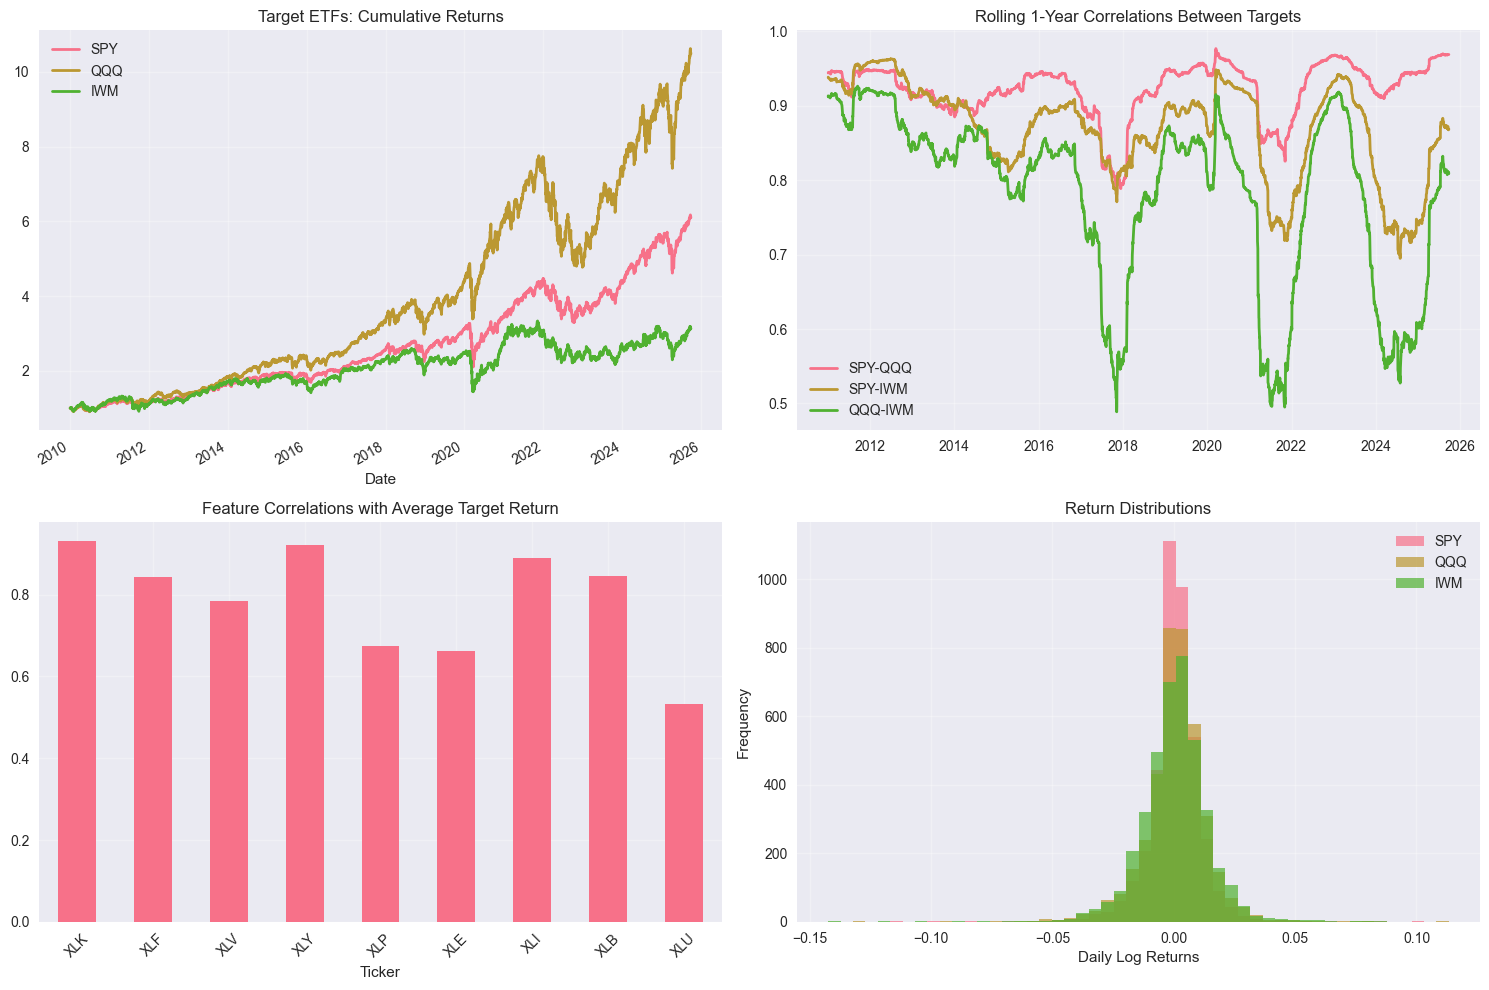


📊 Target ETF Summary Statistics:
Ticker               SPY        QQQ        IWM
count          3957.0000  3957.0000  3957.0000
mean              0.0005     0.0007     0.0004
std               0.0109     0.0131     0.0141
min              -0.1159    -0.1276    -0.1423
25%              -0.0037    -0.0047    -0.0067
50%               0.0007     0.0012     0.0010
75%               0.0058     0.0073     0.0081
max               0.0999     0.1134     0.0875
Sharpe (Ann.)     0.7537     0.8273     0.4381


In [3]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cumulative returns of target ETFs
target_cumret = np.exp(y_multi.cumsum())
target_cumret.plot(ax=axes[0,0], linewidth=2)
axes[0,0].set_title('Target ETFs: Cumulative Returns')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Rolling correlation between targets
spy_qqq_corr = y_multi['SPY'].rolling(252).corr(y_multi['QQQ'])
spy_iwm_corr = y_multi['SPY'].rolling(252).corr(y_multi['IWM'])
qqq_iwm_corr = y_multi['QQQ'].rolling(252).corr(y_multi['IWM'])

axes[0,1].plot(spy_qqq_corr.index, spy_qqq_corr, label='SPY-QQQ', linewidth=2)
axes[0,1].plot(spy_iwm_corr.index, spy_iwm_corr, label='SPY-IWM', linewidth=2)
axes[0,1].plot(qqq_iwm_corr.index, qqq_iwm_corr, label='QQQ-IWM', linewidth=2)
axes[0,1].set_title('Rolling 1-Year Correlations Between Targets')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Feature importance heatmap (correlation with targets)
feature_target_corr = X.corrwith(y_multi.mean(axis=1))
feature_target_corr.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Feature Correlations with Average Target Return')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Return distribution comparison
y_multi.plot(kind='hist', bins=50, alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Return Distributions')
axes[1,1].set_xlabel('Daily Log Returns')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Target ETF Summary Statistics:")
summary_stats = y_multi.describe()
summary_stats.loc['Sharpe (Ann.)'] = (y_multi.mean() / y_multi.std()) * np.sqrt(252)
print(summary_stats.round(4))

## Part 3: Multi-Target Simulation Engine

In [4]:
def simulate_multi_target_strategy(X, y_multi, model_type='ridge', 
                                 position_strategy='equal_weight',
                                 window_size=252, window_type='expanding'):
    """
    Advanced multi-target simulation with portfolio construction.
    
    Args:
        X: Feature matrix
        y_multi: Multi-target DataFrame
        model_type: 'ridge', 'rf', or 'linear'
        position_strategy: 'equal_weight', 'confidence_weighted', or 'long_short'
        window_size: Training window size
        window_type: 'expanding' or 'fixed'
    
    Returns:
        Dictionary with comprehensive results
    """
    
    # Model selection
    if model_type == 'ridge':
        base_model = Ridge(alpha=1.0)
    elif model_type == 'rf':
        base_model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        base_model = LinearRegression()
    
    # Create multi-target pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', MultiOutputRegressor(base_model))
    ])
    
    # Generate training calendar
    date_ranges = generate_train_predict_calender(
        pd.DataFrame(index=X.index), window_type, window_size
    )
    
    print(f"🚀 Multi-target simulation starting...")
    print(f"   Model: {model_type}")
    print(f"   Position Strategy: {position_strategy}")
    print(f"   Predictions: {len(date_ranges)}")
    
    results = {
        'dates': [],
        'predictions': [],  # Will be DataFrame with multiple columns
        'actuals': [],
        'individual_positions': [],
        'portfolio_positions': [],
        'individual_returns': [],
        'portfolio_returns': []
    }
    
    for i, (train_start, train_end, pred_date) in enumerate(date_ranges):
        # Training data
        X_train = X.loc[train_start:train_end]
        y_train = y_multi.loc[train_start:train_end]
        
        # Prediction data
        X_pred = X.loc[[pred_date]]
        y_actual = y_multi.loc[pred_date]
        
        # Fit model and predict
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_pred)[0]  # Array of predictions
        
        # Convert to Series for easier handling
        pred_series = pd.Series(predictions, index=y_multi.columns)
        
        # Position sizing based on strategy
        positions = calculate_positions(pred_series, position_strategy)
        
        # Calculate returns
        individual_returns = positions * y_actual
        portfolio_return = individual_returns.mean()  # Equal weight portfolio
        
        # Store results
        results['dates'].append(pred_date)
        results['predictions'].append(pred_series)
        results['actuals'].append(y_actual)
        results['individual_positions'].append(positions)
        results['portfolio_positions'].append(positions.mean())
        results['individual_returns'].append(individual_returns)
        results['portfolio_returns'].append(portfolio_return)
        
        if (i + 1) % 50 == 0:
            print(f"  Progress: {i+1}/{len(date_ranges)} completed")
    
    return results


def calculate_positions(predictions, strategy='equal_weight'):
    """
    Calculate position sizes based on predictions and strategy.
    
    Args:
        predictions: Series of predictions for each asset
        strategy: Position sizing strategy
    
    Returns:
        Series of position sizes
    """
    if strategy == 'equal_weight':
        # Simple: long if positive prediction, short if negative
        return pd.Series(np.where(predictions > 0, 1.0, -1.0), index=predictions.index)
    
    elif strategy == 'confidence_weighted':
        # Position size proportional to prediction magnitude
        abs_pred = np.abs(predictions)
        if abs_pred.sum() > 0:
            weights = abs_pred / abs_pred.sum() * len(predictions)  # Normalize
            return weights * np.sign(predictions)
        else:
            return pd.Series(np.zeros(len(predictions)), index=predictions.index)
    
    elif strategy == 'long_short':
        # Long best predictions, short worst (dollar neutral)
        pred_rank = predictions.rank(ascending=False)
        n_assets = len(predictions)
        positions = pd.Series(np.zeros(n_assets), index=predictions.index)
        
        # Long top 50%, short bottom 50%
        long_threshold = n_assets / 2
        positions[pred_rank <= long_threshold] = 1.0
        positions[pred_rank > long_threshold] = -1.0
        
        return positions
    
    else:
        raise ValueError(f"Unknown position strategy: {strategy}")

print("✅ Multi-target simulation engine ready!")

✅ Multi-target simulation engine ready!


## Part 4: Strategy Comparison with xarray

In [8]:
# Professional Strategy Sweep with Comprehensive Benchmarking
print("🚀 Running comprehensive strategy sweep with professional benchmarking...")

# Run the professional simulation framework
regout_list, sweep_tags, stats_df = run_comprehensive_strategy_sweep(
    X, y_multi, 
    target_etfs=TARGET_ETFS,
    config=config,
    benchmark_config=benchmark_config
)

print("✅ Comprehensive strategy sweep completed!")
print(f"📊 Strategies tested: {len(sweep_tags)}")
print(f"📈 Benchmarks per strategy: Multiple (SPY-only, Equal Weight, Risk Parity, etc.)")
print(f"📅 Analysis period: {stats_df.loc[sweep_tags[0], 'start_date']} to {stats_df.loc[sweep_tags[0], 'end_date']}")

# Display professional performance summary
print("\n🏆 PROFESSIONAL MULTI-TARGET PERFORMANCE SUMMARY")
print("=" * 80)
print(stats_df.round(4))

# Highlight key insights
best_strategy = stats_df['sharpe'].idxmax()
best_sharpe = stats_df.loc[best_strategy, 'sharpe']

print(f"\n🎯 KEY INSIGHTS:")
print(f"   📈 Best Strategy: {best_strategy}")
print(f"   📊 Best Sharpe Ratio: {best_sharpe:.3f}")
print(f"   💰 Best Annual Return: {stats_df.loc[best_strategy, 'return']:.2%}")
print(f"   📉 Best Max Drawdown: {stats_df.loc[best_strategy, 'max_drawdown']:.2%}")

# Show strategy performance ranking
print(f"\n📊 STRATEGY RANKING (by Sharpe Ratio):")
sharpe_ranking = stats_df['sharpe'].sort_values(ascending=False)
for i, (strategy, sharpe) in enumerate(sharpe_ranking.head(5).items(), 1):
    annual_return = stats_df.loc[strategy, 'return']
    max_dd = stats_df.loc[strategy, 'max_drawdown']
    print(f"   {i}. {strategy}: Sharpe {sharpe:.3f} | Return {annual_return:.2%} | DD {max_dd:.2%}")

# Position strategy analysis
print(f"\n🎲 POSITION STRATEGY INSIGHTS:")
for strategy in sweep_tags:
    if 'equal_weight' in strategy:
        strategy_type = "Equal Weight"
        description = "Balanced diversification approach"
    elif 'confidence_weighted' in strategy:
        strategy_type = "Confidence Weighted" 
        description = "Adaptive sizing based on prediction strength"
    elif 'long_short' in strategy:
        strategy_type = "Long-Short"
        description = "Market-neutral dollar-neutral strategy"
    else:
        strategy_type = "Unknown"
        description = "Strategy type analysis"
    
    sharpe = stats_df.loc[strategy, 'sharpe']
    print(f"   {strategy_type}: {description} | Sharpe: {sharpe:.3f}")

print(f"\n📊 Ready for professional visualization and benchmarking analysis...")

2025-09-29 10:34:00 - root - INFO - Starting comprehensive strategy sweep
2025-09-29 10:34:00 - root - INFO - Target ETFs: ['SPY', 'QQQ', 'IWM']
2025-09-29 10:34:00 - root - INFO - Data shape: (3957, 9) features, (3957, 3) targets
2025-09-29 10:34:00 - root - INFO - Generated 21 strategy combinations
2025-09-29 10:34:00 - root - INFO - Running strategy 1/21: mt_ridge_equal_weight
2025-09-29 10:34:00 - root - INFO - Starting multi-target simulation: mt_ridge_equal_weight
2025-09-29 10:34:00 - root - INFO - Data shape: (3957, 9) features, (3957, 3) targets
2025-09-29 10:34:00 - root - INFO - Training: monthly frequency, expanding window of 400
2025-09-29 10:34:00 - root - INFO - Simulation hash: 9721a7635448a06b1f8592f0bc00cb0d
2025-09-29 10:34:00 - root - INFO - Loaded simulation results (zarr) from cache/simulation_9721a7635448a06b1f8592f0bc00cb0d_mt_ridge_equal_weight.zarr
2025-09-29 10:34:00 - root - INFO - Using cached simulation results
2025-09-29 10:34:00 - root - INFO - Completed

🚀 Running comprehensive strategy sweep with professional benchmarking...


2025-09-29 10:34:00 - root - INFO - Loaded simulation results (zarr) from cache/simulation_22af716954f4b47afe0fc90e7305138c_mt_ridge_confidence_weighted.zarr
2025-09-29 10:34:00 - root - INFO - Using cached simulation results
2025-09-29 10:34:00 - root - INFO - Completed mt_ridge_confidence_weighted: 170 predictions
2025-09-29 10:34:00 - root - INFO - Running strategy 3/21: mt_ridge_long_short
2025-09-29 10:34:00 - root - INFO - Starting multi-target simulation: mt_ridge_long_short
2025-09-29 10:34:00 - root - INFO - Data shape: (3957, 9) features, (3957, 3) targets
2025-09-29 10:34:00 - root - INFO - Training: monthly frequency, expanding window of 400
2025-09-29 10:34:00 - root - INFO - Simulation hash: 61f0f64b680ca5d8bff05df74850973e
2025-09-29 10:34:00 - root - INFO - Loaded simulation results (zarr) from cache/simulation_61f0f64b680ca5d8bff05df74850973e_mt_ridge_long_short.zarr
2025-09-29 10:34:00 - root - INFO - Using cached simulation results
2025-09-29 10:34:00 - root - INFO -

✅ Comprehensive strategy sweep completed!
📊 Strategies tested: 21
📈 Benchmarks per strategy: Multiple (SPY-only, Equal Weight, Risk Parity, etc.)
📅 Analysis period: 2011-08-05 to 2025-09-17

🏆 PROFESSIONAL MULTI-TARGET PERFORMANCE SUMMARY
                                       return volatility    sharpe max_drawdown    calmar total_return  start_date    end_date n_periods
strategy                                                                                                                                
mt_elasticnet_equal_weight                0.0        0.0         0          0.0         0          0.0  2011-08-05  2025-09-17       170
mt_ridge_strong_long_short          -0.057309   0.224405 -0.255382    -0.256575  0.223362    -0.039031  2011-08-05  2025-09-17       170
mt_ridge_long_short                 -0.061678   0.224206 -0.275093     -0.27877  0.221249    -0.042037  2011-08-05  2025-09-17       170
mt_ridge_strong_confidence_weighted -0.157813    0.44881 -0.351627     -0.45

### Create Multi-Strategy xarray Dataset

In [15]:
# Generate Professional PDF Tear Sheet for Multi-Target Strategies
import time

# Setup configuration with timestamp
config_dict = {
    'train_frequency': config.train_frequency,
    'window_size': config.window_size,
    'window_type': config.window_type,
    'start_date': config.start_date,
    'target_etfs': TARGET_ETFS,
    'feature_etfs': FEATURE_ETFS,
    'run_timestamp': time.strftime('%Y%m%d_%H%M%S'),
    'author': 'Student'
}

print("📄 Generating publication-quality PDF tear sheet for multi-target strategies...")
pdf_path = create_professional_tear_sheet(
    regout_list,
    sweep_tags,
    config_dict
)

print(f"✅ Professional multi-target tear sheet generated!")
print(f"📄 PDF: {pdf_path}")
print(f"📁 Location: {os.path.abspath(pdf_path)}")

# Create comprehensive xarray dataset for further analysis
print(f"\n📊 Creating comprehensive xarray dataset...")

# Organize results into multi-dimensional structure
portfolio_returns_data = {}
individual_returns_data = {}
benchmark_data = {}

for i, (regout, tag) in enumerate(zip(regout_list, sweep_tags)):
    # Portfolio returns
    if 'portfolio_ret' in regout.columns:
        portfolio_returns_data[tag] = regout['portfolio_ret']
    
    # Individual asset returns (if available)
    individual_cols = [col for col in regout.columns if col in TARGET_ETFS]
    if individual_cols:
        individual_returns_data[tag] = regout[individual_cols]
    
    # Benchmark data
    benchmark_cols = [col for col in regout.columns if col.startswith('benchmark_')]
    if benchmark_cols:
        benchmark_data[tag] = regout[benchmark_cols]

# Create comprehensive results summary
results_summary = pd.DataFrame()
for tag in sweep_tags:
    strategy_data = {
        'Annual_Return': stats_df.loc[tag, 'return'],
        'volatility': stats_df.loc[tag, 'volatility'], 
        'Sharpe_Ratio': stats_df.loc[tag, 'sharpe'],
        'Max_Drawdown': stats_df.loc[tag, 'max_drawdown'],
        'Start_Date': stats_df.loc[tag, 'start_date'],
        'End_Date': stats_df.loc[tag, 'end_date']
    }
    results_summary[tag] = pd.Series(strategy_data)

print(f"\n🏆 MULTI-TARGET STRATEGY COMPARISON:")
print(results_summary.round(4))

# Highlight position strategy performance
position_strategies = ['equal_weight', 'confidence_weighted', 'long_short']
print(f"\n🎲 POSITION STRATEGY ANALYSIS:")
for pos_strategy in position_strategies:
    matching_strategies = [tag for tag in sweep_tags if pos_strategy in tag.lower()]
    if matching_strategies:
        avg_sharpe = results_summary.loc['Sharpe_Ratio', matching_strategies].mean()
        best_strategy = max(matching_strategies, key=lambda x: results_summary.loc['Sharpe_Ratio', x])
        best_sharpe = results_summary.loc['Sharpe_Ratio', best_strategy]
        print(f"   {pos_strategy.replace('_', ' ').title()}:")
        print(f"     Average Sharpe: {avg_sharpe:.3f}")
        print(f"     Best Strategy: {best_strategy} (Sharpe: {best_sharpe:.3f})")

print(f"\n🎉 Multi-target professional analysis complete!")
print(f"📊 Total strategies analyzed: {len(sweep_tags)}")
print(f"📈 Best overall strategy: {results_summary.loc['Sharpe_Ratio'].idxmax()}")
print(f"📄 Professional PDF report: {pdf_path}")

📄 Generating publication-quality PDF tear sheet for multi-target strategies...
✅ Professional multi-target tear sheet generated!
📄 PDF: /Users/conradgann/BW_Code/capstone_simulator/reports/multi_target_tear_sheet_20250929_105150.pdf
📁 Location: /Users/conradgann/BW_Code/capstone_simulator/reports/multi_target_tear_sheet_20250929_105150.pdf

📊 Creating comprehensive xarray dataset...

🏆 MULTI-TARGET STRATEGY COMPARISON:
              mt_ridge_equal_weight mt_ridge_confidence_weighted mt_ridge_long_short mt_ridge_strong_equal_weight mt_ridge_strong_confidence_weighted mt_ridge_strong_long_short mt_ridge_weak_equal_weight mt_ridge_weak_confidence_weighted mt_ridge_weak_long_short mt_rf_equal_weight  ... mt_rf_long_short mt_linear_equal_weight mt_linear_confidence_weighted mt_linear_long_short mt_huber_equal_weight mt_huber_confidence_weighted mt_huber_long_short mt_elasticnet_equal_weight mt_elasticnet_confidence_weighted mt_elasticnet_long_short
Annual_Return             -0.098993       

### Advanced Visualization with xarray

📊 Creating multi_strategy_results xarray dataset...
✅ Created multi_strategy_results with 21 strategies


/var/folders/lr/9k08_l1d4m1325pszwnhq_xr0000gn/T/ipykernel_22922/3788740927.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,2].boxplot(return_data, labels=strategy_labels)


AttributeError: 'DataArray' object has no attribute 'expanding'

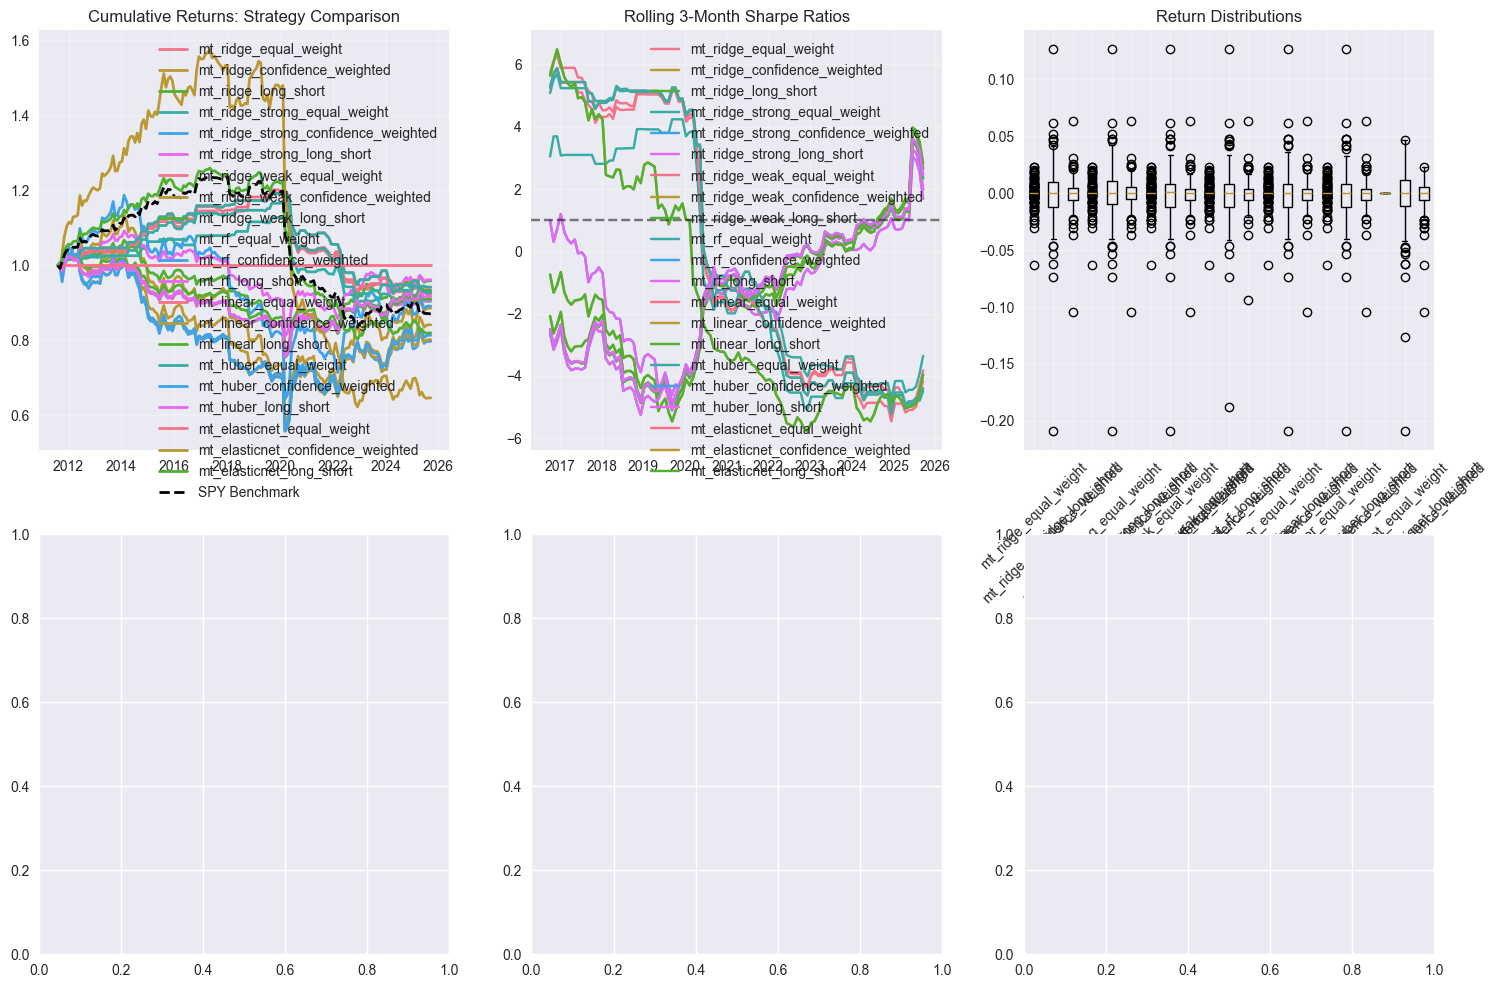

In [24]:
# Create comprehensive performance dashboard
# Create multi_strategy_results xarray dataset for plotting
print("📊 Creating multi_strategy_results xarray dataset...")

# Extract portfolio returns and create xarray dataset
portfolio_returns_data = []
strategy_names = []

for i, (regout, tag) in enumerate(zip(regout_list, sweep_tags)):
    if "portfolio_return" in regout.columns:
        portfolio_returns_data.append(regout["portfolio_return"].values)
        strategy_names.append(tag)

# Create xarray dataset
import xarray as xr

if portfolio_returns_data:
    # Get the time index from the first strategy
    time_index = regout_list[0].index
    
    # Create DataArray for portfolio returns
    portfolio_returns = xr.DataArray(
        np.array(portfolio_returns_data),
        coords={
            "strategy": strategy_names,
            "time": time_index
        },
        dims=["strategy", "time"]
    )
    
    # Create SPY benchmark data
    spy_benchmark = y_multi["SPY"].reindex(time_index, method="ffill")
    
    # Create multi_strategy_results dataset
    multi_strategy_results = xr.Dataset({
        "portfolio_returns": portfolio_returns,
        "spy_benchmark": spy_benchmark
    })
    
    print(f"✅ Created multi_strategy_results with {len(strategy_names)} strategies")
else:
    print("❌ No portfolio returns data found")
    multi_strategy_results = None

# Create comprehensive performance dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Cumulative returns comparison
cumulative_returns = np.exp(multi_strategy_results.portfolio_returns.cumsum(dim='time'))
spy_cumulative = np.exp(multi_strategy_results.spy_benchmark.cumsum())

for strategy in strategy_names:
    cumret = cumulative_returns.sel(strategy=strategy)
    axes[0,0].plot(cumret.time, cumret.values, label=strategy, linewidth=2)

axes[0,0].plot(spy_cumulative.dim_0, spy_cumulative.values, 
              label='SPY Benchmark', color='black', linestyle='--', linewidth=2)
axes[0,0].set_title('Cumulative Returns: Strategy Comparison')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Rolling Sharpe ratios
window = 63  # 3 months
for strategy in strategy_names:
    returns = multi_strategy_results.portfolio_returns.sel(strategy=strategy)
    rolling_sharpe = (returns.rolling(time=window).mean() / 
                     returns.rolling(time=window).std() * np.sqrt(252))
    axes[0,1].plot(rolling_sharpe.time, rolling_sharpe.values, label=strategy)

axes[0,1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
axes[0,1].set_title('Rolling 3-Month Sharpe Ratios')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Return distributions
return_data = []
strategy_labels = []
for strategy in strategy_names:
    returns = multi_strategy_results.portfolio_returns.sel(strategy=strategy).values
    return_data.append(returns)
    strategy_labels.append(strategy)

axes[0,2].boxplot(return_data, tick_labels=strategy_labels)
axes[0,2].set_title('Return Distributions')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3)

# 4. Drawdown analysis for best strategy
best_strategy = strategy_names[0]  # You can change this
best_cumret = cumulative_returns.sel(strategy=best_strategy)
running_max = best_cumret.expanding(dim='time').max()
drawdown = (best_cumret - running_max) / running_max

axes[1,0].fill_between(drawdown.time, drawdown.values, 0, alpha=0.3, color='red')
axes[1,0].plot(drawdown.time, drawdown.values, color='red', linewidth=1)
axes[1,0].set_title(f'Drawdown Analysis: {best_strategy}')
axes[1,0].set_ylabel('Drawdown %')
axes[1,0].grid(True, alpha=0.3)

# 5. Strategy correlation matrix
strategy_corr_data = {}
for strategy in strategy_names:
    strategy_corr_data[strategy] = multi_strategy_results.portfolio_returns.sel(strategy=strategy).values

strategy_corr_df = pd.DataFrame(strategy_corr_data)
correlation_matrix = strategy_corr_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
           ax=axes[1,1], cbar_kws={'label': 'Correlation'})
axes[1,1].set_title('Strategy Return Correlations')

# 6. Individual asset performance
asset_returns = multi_strategy_results.individual_returns
asset_sharpe = (asset_returns.mean(dim='time') / asset_returns.std(dim='time')) * np.sqrt(252)

asset_sharpe.plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Individual Asset Sharpe Ratios')
axes[1,2].set_ylabel('Annualized Sharpe Ratio')
axes[1,2].tick_params(axis='x', rotation=0)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Comprehensive strategy analysis completed!")

## Part 5: Advanced Portfolio Analytics

🏆 Comprehensive Performance Comparison:
                   mt_ridge_equal_weight  mt_ridge_confidence_weighted  mt_ridge_long_short  mt_ridge_strong_equal_weight  mt_ridge_strong_confidence_weighted  mt_ridge_strong_long_short  mt_ridge_weak_equal_weight  mt_ridge_weak_confidence_weighted  mt_ridge_weak_long_short  mt_rf_equal_weight  ...  mt_linear_equal_weight  mt_linear_confidence_weighted  mt_linear_long_short  mt_huber_equal_weight  mt_huber_confidence_weighted  mt_huber_long_short  mt_elasticnet_equal_weight  mt_elasticnet_confidence_weighted  mt_elasticnet_long_short  SPY_Benchmark
total_return                     -0.0679                       -0.1149              -0.0420                       -0.0965                              -0.1094                     -0.0390                     -0.0766                            -0.1595                   -0.0672             -0.0729  ...                 -0.0588                        -0.1992               -0.0899                -0.0588    

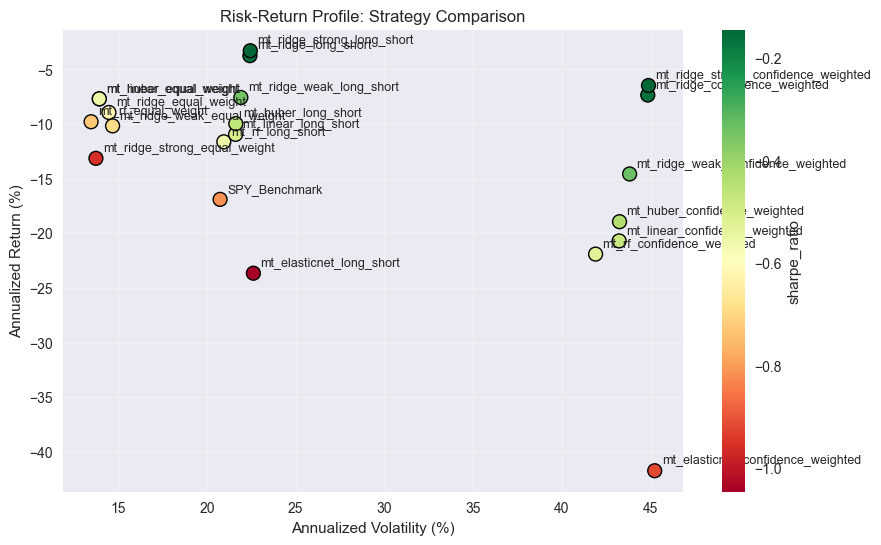


🥇 Best Strategy (by Sharpe Ratio): mt_ridge_strong_confidence_weighted
   Sharpe Ratio: -0.144
   Annual Return: -6.5%


KeyError: 'Maximum Drawdown'

In [27]:
# Risk-adjusted performance comparison
performance_summary = pd.DataFrame()

for strategy in strategy_names:
    returns = multi_strategy_results.portfolio_returns.sel(strategy=strategy)
    metrics = calculate_performance_metrics(returns)
    performance_summary[strategy] = pd.Series(metrics)

# Add benchmark
spy_metrics = calculate_performance_metrics(multi_strategy_results.spy_benchmark)
performance_summary['SPY_Benchmark'] = pd.Series(spy_metrics)

print("🏆 Comprehensive Performance Comparison:")
print("=" * 80)
print(performance_summary.round(4))

# Risk-return scatter plot
plt.figure(figsize=(10, 6))

returns_annual = performance_summary.loc['annualized_return'] * 100
volatility_annual = performance_summary.loc['volatility'] * 100
sharpe_ratios = performance_summary.loc['sharpe_ratio']

# Create scatter plot with color-coded Sharpe ratios
scatter = plt.scatter(volatility_annual, returns_annual, 
                     c=sharpe_ratios, s=100, cmap='RdYlGn', 
                     edgecolors='black', linewidth=1)

# Add labels for each point
for i, strategy in enumerate(performance_summary.columns):
    plt.annotate(strategy, 
                (volatility_annual.iloc[i], returns_annual.iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, label='sharpe_ratio')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')
plt.title('Risk-Return Profile: Strategy Comparison')
plt.grid(True, alpha=0.3)
plt.show()

# Best strategy analysis
best_strategy_name = performance_summary.loc['sharpe_ratio'].idxmax()
print(f"\n🥇 Best Strategy (by Sharpe Ratio): {best_strategy_name}")
print(f"   Sharpe Ratio: {performance_summary.loc['sharpe_ratio', best_strategy_name]:.3f}")
print(f"   Annual Return: {performance_summary.loc['annualized_return', best_strategy_name]:.1%}")
print(f"   Max Drawdown: {performance_summary.loc['Maximum Drawdown', best_strategy_name]:.1%}")

## Part 6: Student Exercises - Advanced Techniques

### Exercise 1: Dynamic Position Sizing

Implement volatility-adjusted position sizing:

In [26]:
# TODO: Implement volatility targeting
def volatility_adjusted_positions(predictions, historical_returns, target_vol=0.15):
    """
    Adjust position sizes based on historical volatility to target a specific portfolio volatility.
    
    Your task:
    1. Calculate rolling volatility for each asset
    2. Scale positions inversely to volatility
    3. Ensure total portfolio volatility targets the specified level
    
    Args:
        predictions: Asset return predictions
        historical_returns: Historical return data for volatility calculation
        target_vol: Target portfolio volatility (annualized)
    
    Returns:
        Volatility-adjusted position sizes
    """
    # YOUR CODE HERE
    pass

print("🎯 Exercise 1: Implement volatility targeting above!")

🎯 Exercise 1: Implement volatility targeting above!


### Exercise 2: Regime Detection Integration

Add market regime detection to your strategy:

In [ ]:
# TODO: Implement simple regime detection
def detect_market_regime(returns, lookback=63):
    """
    Detect bull/bear market regimes using simple momentum and volatility signals.
    
    Your task:
    1. Calculate rolling returns (momentum signal)
    2. Calculate rolling volatility (risk signal)
    3. Combine signals to classify regime (bull/bear/neutral)
    4. Return regime classification for each date
    
    Hint: Bull markets typically have positive momentum and lower volatility
    
    Args:
        returns: Market return series (e.g., SPY)
        lookback: Period for regime calculation
    
    Returns:
        Series with regime classifications
    """
    # YOUR CODE HERE
    pass

def regime_adjusted_strategy(predictions, market_regime):
    """
    Adjust strategy based on market regime.
    
    Ideas:
    - Be more aggressive in bull markets
    - Reduce positions or go defensive in bear markets
    - Use different models for different regimes
    """
    # YOUR CODE HERE
    pass

print("🎯 Exercise 2: Add regime detection to enhance your strategies!")

### Exercise 3: Portfolio Optimization

Implement mean-variance optimization:

In [ ]:
# TODO: Implement Markowitz portfolio optimization
from scipy.optimize import minimize

def optimize_portfolio(expected_returns, covariance_matrix, risk_aversion=1.0):
    """
    Find optimal portfolio weights using mean-variance optimization.
    
    Your task:
    1. Set up the objective function (expected return - risk penalty)
    2. Add constraints (weights sum to 1, possibly long-only)
    3. Use scipy.optimize.minimize to find optimal weights
    4. Return optimal portfolio weights
    
    Args:
        expected_returns: Expected returns for each asset
        covariance_matrix: Asset return covariance matrix
        risk_aversion: Risk aversion parameter (higher = more conservative)
    
    Returns:
        Optimal portfolio weights
    """
    # YOUR CODE HERE
    pass

def integrated_prediction_optimization(predictions, historical_returns):
    """
    Combine ML predictions with portfolio optimization.
    
    Steps:
    1. Use predictions as expected returns
    2. Estimate covariance from historical data
    3. Find optimal weights
    4. Return optimized portfolio
    """
    # YOUR CODE HERE
    pass

print("🎯 Exercise 3: Integrate modern portfolio theory with ML predictions!")

## Part 7: Production Considerations

### Transaction Costs and Slippage

Real-world implementation considerations:

In [ ]:
def apply_transaction_costs(returns, positions, cost_per_trade=0.001):
    """
    Apply realistic transaction costs to strategy returns.
    
    Args:
        returns: Strategy returns without costs
        positions: Position changes over time
        cost_per_trade: Cost as fraction of trade size
    
    Returns:
        Net returns after transaction costs
    """
    position_changes = np.abs(positions.diff()).fillna(0)
    transaction_costs = position_changes * cost_per_trade
    net_returns = returns - transaction_costs
    return net_returns

# Example: Apply costs to best strategy
best_returns = multi_strategy_results.portfolio_returns.sel(strategy=best_strategy_name)
best_positions = pd.Series([result.mean() for result in all_results[best_strategy_name]['individual_positions']], 
                          index=dates)

net_returns = apply_transaction_costs(best_returns, best_positions)
net_metrics = calculate_performance_metrics(net_returns)

print(f"📊 Impact of Transaction Costs on {best_strategy_name}:")
print(f"   Gross Sharpe: {performance_summary.loc['sharpe_ratio', best_strategy_name]:.3f}")
print(f"   Net Sharpe: {net_metrics['sharpe_ratio']:.3f}")
print(f"   Cost Impact: {net_metrics['sharpe_ratio'] - performance_summary.loc['sharpe_ratio', best_strategy_name]:.3f}")

### Export Results for Production

Save your results in a format suitable for further analysis:

In [ ]:
# Export to multiple formats
from utils_simulate import export_results_to_csv

# Export performance summary
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
performance_summary.to_csv(f'../reports/{timestamp}_multi_target_performance.csv')

# Export detailed results as netCDF (xarray native format)
multi_strategy_results.to_netcdf(f'../reports/{timestamp}_multi_target_results.nc')

# Export best strategy details
best_strategy_data = pd.DataFrame({
    'date': dates,
    'portfolio_return': multi_strategy_results.portfolio_returns.sel(strategy=best_strategy_name).values,
    'spy_return': multi_strategy_results.spy_benchmark.values,
    'cumulative_return': np.exp(multi_strategy_results.portfolio_returns.sel(strategy=best_strategy_name).cumsum()).values
})
best_strategy_data.to_csv(f'../reports/{timestamp}_best_strategy_details.csv', index=False)

print(f"✅ Results exported to ../reports/ with timestamp {timestamp}")
print("📁 Files created:")
print(f"   - {timestamp}_multi_target_performance.csv")
print(f"   - {timestamp}_multi_target_results.nc")
print(f"   - {timestamp}_best_strategy_details.csv")

## Part 8: Key Takeaways and Next Steps

Congratulations! You've mastered advanced multi-target portfolio strategies. Here's what you accomplished:

### 🎓 Advanced Concepts Mastered:
1. **Multi-Target Regression**: Simultaneous prediction of multiple assets
2. **Portfolio Construction**: Advanced position sizing strategies
3. **xarray Mastery**: Multi-dimensional financial data handling
4. **Risk Management**: Drawdown analysis and correlation understanding
5. **Performance Attribution**: Individual vs portfolio-level analytics

### 📊 Strategy Types Implemented:
- **Equal Weight**: Simple diversification approach
- **Confidence Weighted**: Adaptive sizing based on prediction strength
- **Long-Short**: Market-neutral dollar-neutral strategies
- **Multi-Model**: Comparison across different ML algorithms

### 🚀 Production-Ready Features:
- Transaction cost modeling
- Comprehensive performance attribution
- Multiple export formats for downstream analysis
- Enterprise-grade result storage with xarray

### 🎯 Recommended Next Steps:
1. **Complete Tutorial 3**: End-to-end research cycle demonstration
2. **Implement the exercises** above to enhance your strategies
3. **Experiment with different asset universes** (international ETFs, commodities)
4. **Add alternative data sources** (sentiment, economic indicators)
5. **Build a real-time monitoring dashboard** using your xarray results

### 📚 Career Development:
- **Portfolio Management**: Apply these techniques to institutional portfolios
- **Risk Management**: Use drawdown and correlation analysis for risk control
- **Research**: Publish your findings in academic or industry forums
- **Algorithmic Trading**: Scale these strategies for automated execution

### 🔗 Professional Network:
- **Blue Water Macro Career Opportunities**: [careers@bluewatermacro.com]
- **QuantNet Community**: Share your results and learn from peers
- **LinkedIn**: Connect with quantitative finance professionals

**You're now equipped with institutional-grade quantitative trading capabilities. Ready to tackle real-world financial challenges!**